# Power Aware Collective Communication | Real Trace Generator


*Author: Yuxuan Lin (yl6061@columbia.edu)*

This notebook can be executed directly on **Google Colab** using a free Tesla T4 GPU.  
To run the entire workflow:
1. Open the notebook in Colab.  
2. Navigate to **Runtime → Run all**.  
3. Wait for the profiling and power logging scripts to complete (6 mins expected).  

No additional configuration is required.

### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

In [2]:
%%python --version

Python 3.12.12


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!mkdir -p "/content/gdrive/My Drive/llama32_profile/trace"


### Unsloth

In [6]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.5: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [7]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.10.5 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the `Llama-3.1` format for conversation style finetunes. We use [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we convert it to HuggingFace's normal multiturn format `("role", "content")` instead of `("from", "value")`/ Llama-3 renders multi turn conversations like below:

```
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hello!<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hey there! How are you?<|eot_id|><|start_header_id|>user<|end_header_id|>

I'm great thanks!<|eot_id|>
```

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3` and more.

In [8]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

from datasets import load_dataset
dataset = load_dataset("mlabonne/FineTome-100k", split = "train")

We now use `standardize_sharegpt` to convert ShareGPT style datasets into HuggingFace's generic format. This changes the dataset from looking like:
```
{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What is 2+2?"}
{"from": "gpt", "value": "It's 4."}
```
to
```
{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What is 2+2?"}
{"role": "assistant", "content": "It's 4."}
```

In [9]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

We look at how the conversations are structured for item 5:

In [10]:
dataset[5]["conversations"]

[{'content': 'How do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?',
  'role': 'user'},
 {'content': 'Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.',
  'role': 'assistant'}]

And we see how the chat template transformed these conversations.

**[Notice]** Llama 3.1 Instruct's default chat template default adds `"Cutting Knowledge Date: December 2023\nToday Date: 26 July 2024"`, so do not be alarmed!

In [11]:
dataset[5]["text"]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [12]:
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorForSeq2Seq
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    packing = False, # Can make training 5x faster for short sequences.
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 5,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [13]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

We verify masking is actually done:

In [14]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight rel

In [15]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                  Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|eot_id|>'

We can see the System and Instruction prompts are successfully masked!

In [16]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
3.15 GB of memory reserved.


In [17]:
import pynvml, time, threading, csv
import torch
from torch.profiler import profile, record_function, ProfilerActivity
from transformers import TrainerCallback

# ========== Global timestamp (shared zero point) ==========
global_profiler_start_time = None

# ------------------- Memory Monitor -------------------
class MemoryCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            alloc = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            print(f"[step {int(state.global_step)}] GPU mem: allocated={alloc:.2f} GB, reserved={reserved:.2f} GB")


# ------------------- Profiler -------------------
def run_with_profiler(run_fn, tb_dir="/content/gdrive/MyDrive/llama32_profile/trace",
                      wait=0, warmup=0, active=3):
    global global_profiler_start_time

    # ✅ Set the global timestamp before launching the profiler
    global_profiler_start_time = time.time()
    print(f"🕒 Global start time set at {global_profiler_start_time:.3f}")

    sched = torch.profiler.schedule(wait=wait, warmup=warmup, active=active, repeat=1)
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=sched,
        on_trace_ready=torch.profiler.tensorboard_trace_handler(tb_dir),
        profile_memory=True,
    ) as prof:
        with record_function("Llama3.2_Training"):
            result = run_fn()
    print(f"✅ Trace saved to TensorBoard directory: {tb_dir}")
    return result


# ------------------- NVML Logger -------------------
def power_logger(log_path, interval=0.5, stop_flag=[False]):
    global global_profiler_start_time

    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    with open(log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "power_W", "gpu_util", "mem_util"])
        while not stop_flag[0]:
            t = time.time() - global_profiler_start_time  # ✅ Relative to the same zero point
            power = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000
            util = pynvml.nvmlDeviceGetUtilizationRates(handle)
            writer.writerow([t, power, util.gpu, util.memory])
            time.sleep(interval)
    pynvml.nvmlShutdown()


# ------------------- Launch training -------------------
trainer.add_callback(MemoryCallback())

stop_flag = [False]
log_path = "/content/gdrive/MyDrive/llama32_profile/trace/power_log.csv"

# Start power logger first
power_thread = threading.Thread(target=power_logger, args=(log_path, 0.1, stop_flag))
power_thread.start()
print("⚡ NVML power logging started...")

# Wrap training with profiler
trainer_stats = run_with_profiler(lambda: trainer.train())

# Stop power sampling
stop_flag[0] = True
power_thread.join()
print("⚡ NVML power logging stopped.")

⚡ NVML power logging started...
🕒 Global start time set at 1760746043.954


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.775000
2,0.839100
3,1.075800
4,0.891900
5,0.757600


[step 1] GPU mem: allocated=2.60 GB, reserved=3.53 GB
[step 2] GPU mem: allocated=2.60 GB, reserved=6.01 GB
[step 3] GPU mem: allocated=2.60 GB, reserved=6.01 GB
[step 4] GPU mem: allocated=2.60 GB, reserved=6.01 GB
[step 5] GPU mem: allocated=2.60 GB, reserved=6.01 GB
✅ Trace saved to TensorBoard directory: /content/gdrive/MyDrive/llama32_profile/trace
⚡ NVML power logging stopped.


In [18]:
# @title Check available traces
%ls /content/gdrive/MyDrive/llama32_profile/trace

38ee4810de55_11804.1760746104757352613.pt.trace.json
52342518567e_33812.1760309555564334652.pt.trace.json
52342518567e_33812.1760310096314773217.pt.trace.json
power_log.csv


In [19]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

45.8393 seconds used for training.
0.76 minutes used for training.
Peak reserved memory = 5.598 GB.
Peak reserved memory for training = 2.448 GB.
Peak reserved memory % of max memory = 37.976 %.
Peak reserved memory for training % of max memory = 16.607 %.


        timestamp     power_W    gpu_util    mem_util
count  415.000000  415.000000  415.000000  415.000000
mean    26.474904   59.656586   60.669880   35.898795
std     13.600311   16.265328   38.316246   21.231627
min      0.005780   29.297000    0.000000    0.000000
25%     14.954409   44.137000   23.000000   17.500000
50%     26.652387   66.669000   71.000000   46.000000
75%     38.220799   71.379000   97.000000   53.000000
max     60.802500   97.849000  100.000000   66.000000
⚡ Average Power: 59.66 W
🚀 Peak Power: 97.85 W


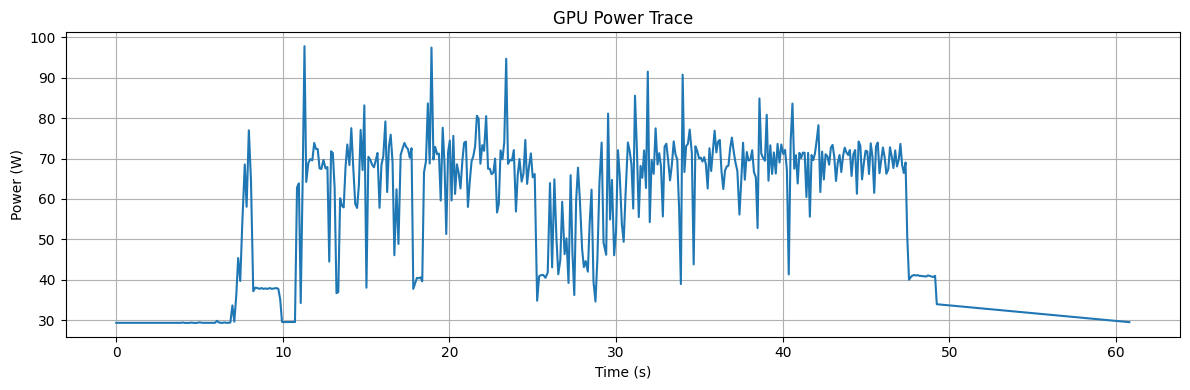

In [20]:
# @title Show GPU Power usage across time
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/gdrive/MyDrive/llama32_profile/trace/power_log.csv")
print(df.describe())

avg_power = df["power_W"].mean()
peak_power = df["power_W"].max()
print(f"⚡ Average Power: {avg_power:.2f} W")
print(f"🚀 Peak Power: {peak_power:.2f} W")


# Visualization
plt.figure(figsize=(12, 4))
plt.plot(df["timestamp"], df["power_W"])
plt.title("GPU Power Trace")
plt.xlabel("Time (s)")
plt.ylabel("Power (W)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# === In-Progress: Align profiler events to NVML power onset and visualize ===
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRACE_DIR = "/content/gdrive/My Drive/llama32_profile/trace"
POWER_CSV = "/content/gdrive/My Drive/llama32_profile/trace/power_log.csv"

# ---------------------------------------------------------------------
# 1) Load NVML power log (timestamps are seconds since global_profiler_start_time)
# ---------------------------------------------------------------------
dfp = pd.read_csv(POWER_CSV)
assert len(dfp) > 0, "power_log.csv is empty"
dfp = dfp.sort_values("timestamp").reset_index(drop=True)

# --- Detect power-onset (first significant rise above idle baseline) ---
# Use the first ~2s to estimate idle power
idle_win = dfp[dfp["timestamp"] <= 2.0]["power_W"]
baseline = idle_win.mean() if len(idle_win) else dfp.iloc[:max(1, min(5, len(dfp)))]["power_W"].mean()
threshold = baseline + 10.0  # idle baseline + 10 W (tunable threshold)

rise_idx = dfp.index[dfp["power_W"] > threshold]
if len(rise_idx) == 0:
    # No clear rise detected — fallback to earliest timestamp
    t_power_start = float(dfp["timestamp"].iloc[0])
else:
    t_power_start = float(dfp.loc[rise_idx[0], "timestamp"])

print(f"⚡ Detected power onset at ~{t_power_start:.3f} s after logging starts "
      f"(baseline={baseline:.1f}W, threshold={threshold:.1f}W)")

# ---------------------------------------------------------------------
# 2) Load the latest profiler trace
# ---------------------------------------------------------------------
cands = sorted(glob.glob(os.path.join(TRACE_DIR, "*.pt.trace.json")))
assert cands, f"No trace files found in {TRACE_DIR}"
trace_path = cands[-1]
with open(trace_path, "r") as f:
    trace = json.load(f)

events_all = trace["traceEvents"]

def is_compute(name: str) -> bool:
    """Return True if the op name looks like a compute operation."""
    n = name.lower()
    return ("aten::" in n) or ("gemm" in n) or ("matmul" in n)

# Filter for compute events only
compute_events = [e for e in events_all if e.get("ph") == "X" and is_compute(e.get("name", ""))]
print(f"✅ Loaded {len(events_all)} total events, {len(compute_events)} compute events")

# ---------------------------------------------------------------------
# 3) Build relative timestamps (relative to the first compute event)
# ---------------------------------------------------------------------
first_ts = min(e["ts"] for e in compute_events)
for e in compute_events:
    e["t_rel"] = (e["ts"] - first_ts) / 1e9  # seconds since first compute event

# # ---------------------------------------------------------------------
# # 4) Align event timeline with power onset
# #    (i.e., shift entire event timeline so t=0 aligns with NVML onset)
# # ---------------------------------------------------------------------
# for e in compute_events:
#     e["t_aligned"] = e["t_rel"] + t_power_start

# # ---------------------------------------------------------------------
# # 5) Pick top-5 longest compute events
# # ---------------------------------------------------------------------
# top5 = sorted(compute_events, key=lambda x: x.get("dur", 0), reverse=True)[:5]
# print("🏆 Top 5 compute events:")
# for i, e in enumerate(top5, 1):
#     print(f"  {i}. {e['name']} @ {e['t_aligned']:.3f}s (aligned to power)  "
#           f"dur={e['dur']:.1f}us")

# # ---------------------------------------------------------------------
# # 6) Visualization: power curve + top-5 compute events
# # ---------------------------------------------------------------------
# win = 60.0  # display the first 60 seconds of power data
# mask = (dfp["timestamp"] >= 0.0) & (dfp["timestamp"] <= win)
# df_win = dfp[mask]

# fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(df_win["timestamp"], df_win["power_W"], label="Power (W)", linewidth=1.8)

# Optional: mark top-5 compute events on the plot
# y_marker = df_win["power_W"].max() + 5 if len(df_win) else 100
# ax.scatter(
#     [e["t_aligned"] for e in top5],
#     [y_marker] * len(top5),
#     s=90, color="red", label="Top-5 Compute Events"
# )

# ax.set_xlim(0, win)
# ax.set_xlabel("Time since NVML logging start (s)")
# ax.set_ylabel("Power (W)")
# ax.set_title("Power Trace (Aligned with Profiler Events)")
# ax.legend(loc="upper right")
# plt.tight_layout()
# plt.show()

⚡ Detected power onset at ~7.319 s after logging starts (baseline=29.3W, threshold=39.3W)
✅ Loaded 1280767 total events, 549149 compute events


In [22]:
# @title Show random events
import random

random.seed(42)

sample_events = random.sample(compute_events, 10)

print("🎲 Random 10 compute events:")
for i, e in enumerate(sample_events, 1):
    print(f"Event {i}: name={e['name']}, t_rel={e['t_rel']:.3f}s, dur={e['dur']:.1f}us")

🎲 Random 10 compute events:
Event 1: name=aten::matmul, t_rel=0.021s, dur=127.4us
Event 2: name=aten::t, t_rel=0.014s, dur=2.9us
Event 3: name=aten::mm, t_rel=0.034s, dur=58.8us
Event 4: name=aten::view, t_rel=0.033s, dur=2.4us
Event 5: name=aten::as_strided, t_rel=0.031s, dur=0.7us
Event 6: name=aten::as_strided, t_rel=0.023s, dur=0.9us
Event 7: name=aten::matmul, t_rel=0.019s, dur=88.7us
Event 8: name=aten::as_strided, t_rel=0.018s, dur=1.4us
Event 9: name=aten::reshape, t_rel=0.027s, dur=7.5us
Event 10: name=aten::empty_strided, t_rel=0.015s, dur=6.9us


In [23]:
# @title List top ops and events
import json
from collections import Counter

BYTES_PER_ELEM = 4  # FP32

# ====================== Load profiler trace ======================
cands = sorted(glob.glob(os.path.join(TRACE_DIR, "*.pt.trace.json")))
assert cands, f"No trace files found in {TRACE_DIR}"

# Pick the most recent trace file
best = cands[-1]
with open(best, "r") as f:
    trace = json.load(f)

print(f"✅ Picked trace: {os.path.basename(best)}")

events = trace["traceEvents"]
print(f"✅ Loaded trace with {len(events)} total events")

# ========== Filter Compute / Communication ==========
astra_events = []
for e in events:
    name = e.get("name", "").lower()
    if e.get("ph") != "X":  # Only keep complete events
        continue

    if "nccl" in name:
        op_type = "all_reduce"
    elif "aten::" in name or "gemm" in name or "matmul" in name:
        op_type = "compute"
    else:
        continue

    astra_events.append((op_type, e))

print(f"Filtered {len(astra_events)} useful events (compute+comm)")

# ========== Basic stats ==========
compute_count = sum(1 for op, _ in astra_events if op == "compute")
comm_count = sum(1 for op, _ in astra_events if op == "all_reduce")

print(f"Compute ops: {compute_count}")
print(f"AllReduce ops: {comm_count}")

# ========== Top operator frequency ==========
op_name_counter = Counter(e["name"] for _, e in astra_events)
print("Top 10 ops by frequency:")
for name, count in op_name_counter.most_common(10):
    print(f"  {name}: {count} times")

# ========== Estimate communication size ==========
sizes = []
for op_type, e in astra_events:
    if op_type == "all_reduce":
        shape = e.get("args", {}).get("Input dims")
        if shape:
            numel = 1
            for s in shape[0]:
                numel *= s
            sizes.append(numel * BYTES_PER_ELEM)

if sizes:
    print(f"AllReduce size stats (bytes): min={min(sizes)}, max={max(sizes)}, mean={sum(sizes)/len(sizes):.2f}")
else:
    print("No communication sizes found")

# ========== Preview of events ==========
top5 = sorted(astra_events, key=lambda x: x[1].get("dur", 0), reverse=True)[:5]
for i, (op_type, e) in enumerate(top5, 1):
    print(f"\nEvent {i}")
    print(f"  op_type: {op_type}")
    print(f"  name: {e.get('name')}")
    print(f"  ts: {e.get('ts')}")
    print(f"  dur: {e.get('dur')}")

✅ Picked trace: 52342518567e_33812.1760310096314773217.pt.trace.json
✅ Loaded trace with 1280767 total events
Filtered 549149 useful events (compute+comm)
Compute ops: 549149
AllReduce ops: 0
Top 10 ops by frequency:
  aten::as_strided: 100528 times
  aten::transpose: 59050 times
  aten::t: 48970 times
  aten::view: 38655 times
  aten::matmul: 34949 times
  aten::slice: 28113 times
  aten::empty: 25908 times
  aten::empty_strided: 24209 times
  aten::to: 23751 times
  aten::copy_: 22415 times
No communication sizes found

Event 1
  op_type: compute
  name: turing_fp16_s1688gemm_fp16_256x128_ldg8_f2f_stages_32x1_nn
  ts: 1009992836409.495
  dur: 83444.576

Event 2
  op_type: compute
  name: aten::matmul
  ts: 1009977263491.939
  dur: 74497.34

Event 3
  op_type: compute
  name: aten::matmul
  ts: 1009977264614.419
  dur: 73372.941

Event 4
  op_type: compute
  name: aten::mm
  ts: 1009977264736.344
  dur: 73241.856

Event 5
  op_type: compute
  name: turing_fp16_s1688gemm_fp16_256x128_l

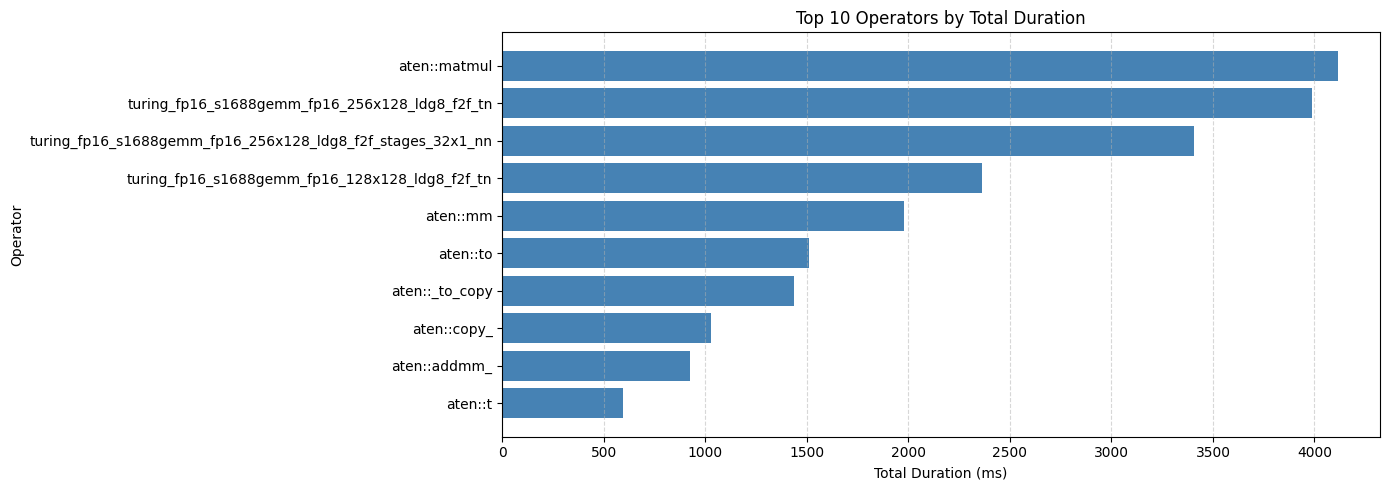

In [24]:
# @title Top N ops by duration
TOP_N = 10

# Sort all events by duration in descending order
sorted_events = sorted(astra_events, key=lambda x: x[1].get("dur", 0), reverse=True)

# Aggregate by op name (same op may appear many times)
dur_per_op = {}
for op_type, e in sorted_events:
    name = e.get("name")
    dur = e.get("dur", 0)
    dur_per_op[name] = dur_per_op.get(name, 0) + dur

# Take top N ops by total duration
top_ops = sorted(dur_per_op.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
op_names = [name for name, _ in top_ops]
op_durations = [dur / 1000 for _, dur in top_ops]  # convert µs → ms

plt.figure(figsize=(14, 5))
plt.barh(op_names[::-1], op_durations[::-1], color='steelblue')
plt.xlabel("Total Duration (ms)")
plt.ylabel("Operator")
plt.title(f"Top {TOP_N} Operators by Total Duration")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now, use have trace for both PyTorch profiler and GPU power!

And we're done! If you have any questions, or find any bugs, or want to keep updated with the project, or need help, feel free to reach out at yl6061@columbia.edu!



---
### Reference:
Unsloth AI. (2024). Unsloth: Lightweight fine-tuning for large language models. Retrieved from https://github.com/unslothai/unsloth

### Appendix
This notebook is built upon Unsloth, a lightweight fine-tuning framework for large language models with optimized memory usage and training efficiency. More Colab training solutions offered by Unsloth for Free:

Notebooks are beginner friendly. Read thier [guide](https://docs.unsloth.ai/get-started/fine-tuning-guide). Add dataset, click "Run All", and export your trained model to GGUF, Ollama, vLLM or Hugging Face.

| Model | Free Notebooks | Performance | Memory use |
|-----------|---------|--------|----------|
| **gpt-oss (20B)**      | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/gpt-oss-(20B)-Fine-tuning.ipynb)               | 1.5x faster | 70% less |
| **Qwen3 (14B)**      | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Qwen3_(14B)-Reasoning-Conversational.ipynb)               | 2x faster | 70% less |
| **Gemma 3n (4B)**      | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Gemma3N_(4B)-Conversational.ipynb)               | 1.5x faster | 50% less |
| **gpt-oss (20B): GRPO**      | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/gpt-oss-(20B)-GRPO.ipynb)               | 2x faster | 80% less |
| **Qwen3-VL (8B): GSPO**      | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Qwen3_VL_(8B)-Vision-GRPO.ipynb)               | 1.5x faster | 80% less |
| **Qwen3-VL (8B)**      | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Qwen3_VL_(8B)-Vision.ipynb)               | 2x faster | 50% less |
| **Gemma 3 (270M)** | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Gemma3_(270M).ipynb)               | 1.7x faster | 60% less |
| **Llama 3.1 (8B)**      | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-Alpaca.ipynb)               | 2x faster | 70% less |
| **Mistral v0.3 (7B)**    | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Mistral_v0.3_(7B)-Conversational.ipynb)               | 2.2x faster | 75% less |
| **Orpheus-TTS (3B)**     | [▶️ Start for free](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Orpheus_(3B)-TTS.ipynb)               | 1.5x faster | 50% less |

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
